In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots

import glob
import pathlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Danych

In [12]:
import json
from pathlib import Path, PurePath
from speed_analyse_scripts.utils import get_latest_file_from_directory
from stitch.rectify.FrameRectifier import FrameRectifier

file_extension = "avi"
# file_extension = "csv"
dir_paths = [
    "resources/speeds/same_wagony/",
    "resources/speeds/full_train/",
    # "resources/speeds/full_train_speed_up/",
]

rectify_config = "resources/best.json"
with open(rectify_config) as f:
    rectify_config = json.load(f)

frame_size = (1920, 1080)
frame_rectifier = FrameRectifier(rectify_config, *frame_size)
frame_rectifier.calc_maps()

files_paths = [get_latest_file_from_directory(dir_path, file_extension) for dir_path in dir_paths]
files_paths = [PurePath(file_path) for file_path in files_paths]

files = {}
for file_path in files_paths:
    parent_dir_name = file_path.parent.name
    files[parent_dir_name] = str(file_path)
    # files[parent_dir_name] = pd.read_csv(file_path)

files


{'same_wagony': 'resources\\speeds\\same_wagony\\same_wagony.avi',
 'full_train': 'resources\\speeds\\full_train\\full_train.avi'}

In [13]:

import copy
from speed_analyse_scripts.utils import Measurement
from stitch.speed.VelocityEstimator import VelocityEstimator
from stitch.speed.regression.LstsqMethod import LstsqMethod
from stitch.speed.regression.OlsMethod import OlsMethod
from stitch.speed.regression.WlsMethod import WlsMethod

velocity_estimators = {
    "lstsq": VelocityEstimator(LstsqMethod(), LstsqMethod()),
    "OLS": VelocityEstimator(OlsMethod(), OlsMethod()),
    "WLS": VelocityEstimator(WlsMethod(), WlsMethod()),
}

raw_velocities = {key: [] for key, value in files.items()}

measurements = []
for file_name in files.keys(): 
    for method_name, estimator in velocity_estimators.items():
        velocity_estimator = copy.deepcopy(estimator)

        measurement = Measurement(file_name, method_name, velocity_estimator, [])
        measurements.append(measurement)

print(raw_velocities)
measurements


{'same_wagony': [], 'full_train': []}


[Measurement(dataset_name='same_wagony', method_name='lstsq', velocity_estimator=<stitch.speed.VelocityEstimator.VelocityEstimator object at 0x000001D8F2244F70>, results=[]),
 Measurement(dataset_name='same_wagony', method_name='OLS', velocity_estimator=<stitch.speed.VelocityEstimator.VelocityEstimator object at 0x000001D8F22448B0>, results=[]),
 Measurement(dataset_name='same_wagony', method_name='WLS', velocity_estimator=<stitch.speed.VelocityEstimator.VelocityEstimator object at 0x000001D8F1EFAB50>, results=[]),
 Measurement(dataset_name='full_train', method_name='lstsq', velocity_estimator=<stitch.speed.VelocityEstimator.VelocityEstimator object at 0x000001D8F1EFA490>, results=[]),
 Measurement(dataset_name='full_train', method_name='OLS', velocity_estimator=<stitch.speed.VelocityEstimator.VelocityEstimator object at 0x000001D8F1EFA070>, results=[]),
 Measurement(dataset_name='full_train', method_name='WLS', velocity_estimator=<stitch.speed.VelocityEstimator.VelocityEstimator objec

In [14]:
import cv2
from tqdm import tqdm

def measure_velocity_from_movie(dataset_name, movie_path, *measurements):
    input_cam = cv2.VideoCapture(movie_path)
    total_frames = input_cam.get(cv2.CAP_PROP_FRAME_COUNT)

    counter = 0
    with tqdm(total=total_frames, desc=dataset_name) as pbar:
        while input_cam.isOpened():
            ret, frame = input_cam.read()

            if ret:
                append_raw_velocity = True
                
                for measurement in measurements:
                    velocity = measurement.velocity_estimator.get_velocity(frame)
                    result = (counter, velocity[0], velocity[1])
                    measurement.results.append(result)

                    if append_raw_velocity:
                        measurement = measurements[0]
                        raw_velocity = measurement.velocity_estimator.old_raw_velocity
                        raw_velocities[dataset_name].append(raw_velocity)
                        append_raw_velocity = False
            else:
                break

            counter += 1
            # print(counter)
            pbar.update(1)

    input_cam.release()

In [15]:
for dataset_name, file_path in files.items():
    selected_measurements = filter(lambda x: x.dataset_name == dataset_name, measurements)
    selected_measurements = list(selected_measurements)

    measure_velocity_from_movie(dataset_name, file_path, *selected_measurements)    
    

same_wagony: 100%|██████████| 308/308.0 [00:51<00:00,  5.96it/s]
full_train: 100%|██████████| 3840/3840.0 [11:11<00:00,  5.72it/s]


In [16]:
dataset_name, movie_path = list(files.items())[0]
selected_measurements = filter(lambda x: x.dataset_name == dataset_name, measurements)
selected_measurements = list(selected_measurements)
selected_measurements

[Measurement(dataset_name='same_wagony', method_name='lstsq', velocity_estimator=<stitch.speed.VelocityEstimator.VelocityEstimator object at 0x000001D8F2244F70>, results=[(0, 0, 0), (1, -8.748497461017811, -0.2986819744110108), (2, -9.546784353226773, -0.28411615977249005), (3, -9.296315149682183, -0.30260792132274056), (4, -9.48185100058194, -0.3252200717230909), (5, -9.302981713112537, -0.30420670625566976), (6, -9.158755382898338, -0.29142728504868576), (7, -9.000799866200143, -0.2644192757435641), (8, -8.933997295167913, -0.2556500559664312), (9, -8.820331645640563, -0.23573884146364757), (10, -8.880825491421712, -0.24624927835412494), (11, -8.796694540184896, -0.22921383230956247), (12, -8.821539248934203, -0.22464881017510985), (13, -8.74642549125144, -0.203852260239871), (14, -8.702321113707569, -0.20230657337661218), (15, -8.60474238563331, -0.18598543946887455), (16, -8.590812879883106, -0.1837624636546029), (17, -8.492174827436285, -0.16526447638612682), (18, -8.5405640121788

In [17]:
from functools import reduce
from speed_analyse_scripts.utils import filter_error

filtered = {}
for key, value in raw_velocities.items():
    if len(value) != 0:
        concatenated_array = reduce(lambda a, b: np.append(a, b, axis=0), value)
        raw_velocities[key] = concatenated_array

        df = pd.DataFrame(concatenated_array)
        headers = ["frame", "x", "y"]
        df.columns = headers
        filtered[key] = filter_error(df).to_numpy()
        

In [18]:
raw_velocities

{'same_wagony': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.00000000e+00, -1.09863281e-03,  7.87353516e-03],
        [ 1.00000000e+00,  3.66210938e-04,  0.00000000e+00],
        ...,
        [ 3.07000000e+02, -2.44140625e-03, -1.22070312e-04],
        [ 3.07000000e+02,  3.66210938e-04,  0.00000000e+00],
        [ 3.07000000e+02,  4.27246094e-04,  1.22070312e-04]]),
 'full_train': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.00000000e+00,  4.76074219e-03,  1.12304688e-02],
        [ 1.00000000e+00,  1.07421875e-02, -5.24902344e-03],
        ...,
        [ 3.83900000e+03,  7.93457031e-03,  3.11279297e-03],
        [ 3.83900000e+03,  1.46484375e-03,  8.23974609e-04],
        [ 3.83900000e+03, -3.05175781e-05, -6.40869141e-04]])}

# Porównanie metod regresji

c:\Users\wrzezniczak\Desktop\onyks_owl\poc\speed_analyse_scripts\ComposedPlot.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()
c:\Users\wrzezniczak\Desktop\onyks_owl\poc\speed_analyse_scripts\ComposedPlot.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


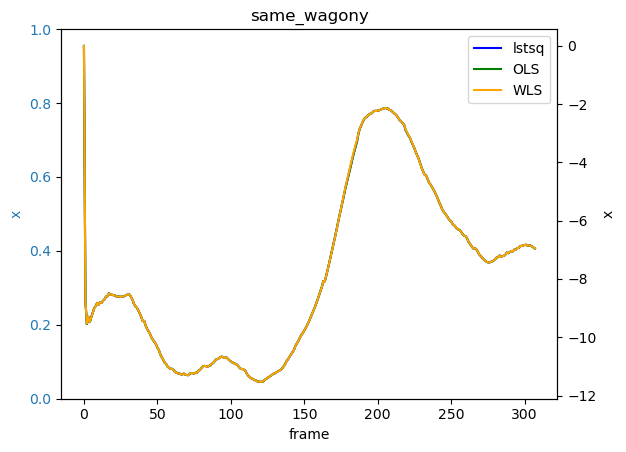

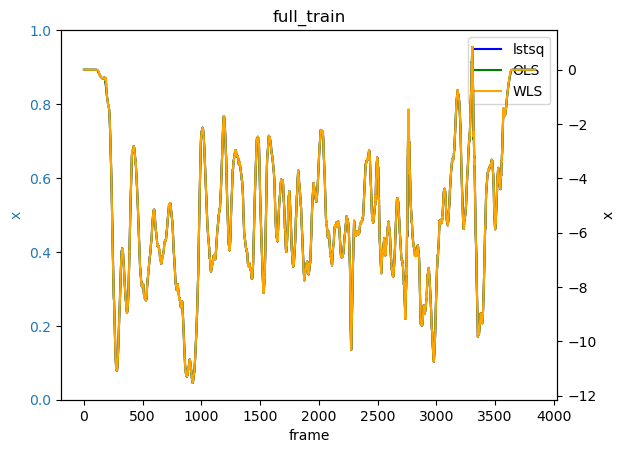

In [26]:
from speed_analyse_scripts.ComposedPlot import ComposedPlot


def ax1_call(axe):
    color = "tab:blue"
    axe.set_xlabel("frame")
    axe.set_ylabel("x", color=color)
    axe.tick_params(axis='y', labelcolor=color)

def ax2_call(axe):
    axe.set_ylabel("x")

for dataset_name in files.keys():
    ax_callbacks = [ax1_call, ax2_call]
    Composed_x = ComposedPlot(dataset_name, *ax_callbacks)	

    colors = ["blue", "green", "orange"]

    # original = raw_velocities[dataset_name] 
    # x = original[:, 0]
    # y = original[:, 1]
    # Composed_x.add_plot(0, x, y, color="grey", label="original x")

    _filtered = filtered[dataset_name] 
    x = _filtered[:, 0]
    y = _filtered[:, 1]
    Composed_x.add_plot(1, x, y, color="red", label="filtered x")
    
    selected_measurements = filter(lambda x: x.dataset_name == dataset_name, measurements)
    selected_measurements = list(selected_measurements)
    for measurement, color in zip(selected_measurements, colors):
        array = np.array(measurement.results)
        x = array[:, 0]
        y = array[:, 1]
        Composed_x.add_plot(1, x, y, color=color, label=measurement.method_name)
    Composed_x.show_composed()